---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [1]:
### Load the imports ### 
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import folium
from branca.colormap import linear
from IPython.display import display
from folium import plugins

--- 

# Utilities

The Utilities Section in this Jupyter Notebook serves as a collection of tools and auxiliary functions designed to streamline common tasks, enhance code efficiency, and provide reusable functionalities.

In [2]:
""" 
We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One
of the challenges is that class definitions tend to be fairly long blocks of code. Notebook
readability demands short code fragments, interspersed with explanations, a requirement
incompatible with the style of programming common for Python libraries. The first utility
function allows us to register functions as methods in a class after the class has been created.
""" 

#Register functions as methods in created class.
def add_to_class(Class): #@save

    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
        return wrapper


--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [5]:
DATABASE_PATH = "Database\database.csv"

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [51]:
"""
Class that manage data and provides methods to visualize it. 
"""

class DataManager(pd.DataFrame):
    
    def load_data(self, filepath):
        try:
            # Load data into the DataFrame itself
            self.__init__(pd.read_csv(filepath))
            self['date'] = pd.to_datetime(self['date'])
            print(f"Data loaded successfully from {filepath}")
        except Exception as e:
            print(f"Error loading data: {e}")

    def date_to_timestamp(self): 
        
        self['timestamp_date'] = pd.to_datetime(self['date'], format='%m/%d/%Y').map(pd.Timestamp.timestamp)

        #convert_to_timestamp = lambda date_str: (
        #    int(datetime.strptime(date_str, "%m/%d/%Y").timestamp()) 
        #    ) if not np.issubdtype(np.array([date_str]).dtype, np.integer) else date_str
        #self['date'] = self['date'].apply(convert_to_timestamp)


    def show_correlation(self,fig, var1, var2): 

        fig.scatter(self[f"{var1}"], self[f"{var2}"], c='blue', alpha=0.7, s=5)
        r=correlation = self[f"{var1}"].corr(self[f"{var2}"])
        r=round(r,3)
        fig.set_title(f"Correlation between {var1} and {var2} (R = {r})")
        fig.set_xlabel(f'{var1}'.upper())
        fig.set_ylabel(f'{var2}'.upper())
        fig.grid(True)

    def show_ppna_fixed_position (self, fig, latitude, longitude):

        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])
        fig.plot(fix_position_df['date'], fix_position_df['ppna'], c='blue')
        fig.set_title("PPNA over time in fixed location")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.grid(True)

    def show_ppna_year_comparision_fixed_position(self, fig, year1, year2, latitude, longitude): 
        
        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])

        for year in fix_position_df['date'].dt.year.unique():
            if year == year1 or year == year2:
                year_data = fix_position_df[fix_position_df['date'].dt.year == year]
                dias_meses = [fecha.strftime('%d-%m') for fecha in year_data['date']]
                fig.plot(dias_meses, year_data['ppna'], label=f'Year {year}')

        # Adjusting the x-axis labels for better readability
        fig.tick_params(axis='x', rotation=45)
        fig.set_title("PPNA Comparison over the years")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.legend()
        fig.grid(True)

    def show_heat_map(self):

        # Crear un mapa centrado en la ubicación media de tus datos
        mapa = folium.Map(location=[self['latitude'].mean(), self['longitude'].mean()], zoom_start=6)

        # Creo un df con fecha, latitude, longitud y valor de la ppna 
        ppna_heatmaptime_df = self[['date','latitude','longitude','ppna']]
        ppna_heatmaptime_df['date'] = ppna_heatmaptime_df['date'].sort_values(ascending=True)
        data = []
        for _, d in ppna_heatmaptime_df.groupby('date'):
            data.append([[row['latitude'], row['longitude'], row['ppna']] for _, row in d.iterrows()])
        data

        #creo el indice de tiempo para graficar en el mapa 
        time_index = list(ppna_heatmaptime_df['date'].astype('str').unique())


        plugins.HeatMapWithTime(data,
                        index=time_index,
                        auto_play=True,
                        radius=10,
                        use_local_extrema=True
                    ).add_to(mapa)


        # Agrego labels
        """
        Lo dejo comentado por que por performance tarda mucho, despues vemos si lo necesitamos como solucionarlo 
        percentage_to_label = 5  # Porcentaje de puntos para los que se agregarán etiquetas
        total_points = sum(len(points) for points in data)
        points_to_label = [point for points in data for point in points if hash(tuple(point)) % 100 < percentage_to_label]

        for lat, lon, value in points_to_label:
            label = value
            folium.Marker(location=[lat, lon], popup=label).add_to(mapa)

        """

        display(mapa)

    def normalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = (self[['ppna', 'ppt', 'temp']] - mean[['ppna', 'ppt', 'temp']]) / std[['ppna', 'ppt', 'temp']]


In [52]:
ppna_df = DataManager()
ppna_df.load_data(DATABASE_PATH) 
ppna_df.info()

Data loaded successfully from Database\database.csv
<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB



## Data Visualization 


In [53]:
ppna_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
id,690000.0,344999.5,0.0,172499.75,344999.5,517499.25,689999.0,199185.987208
date,690000,2010-12-25 12:00:00,2001-01-01 00:00:00,2005-12-28 18:00:00,2010-12-25 12:00:00,2015-12-22 06:00:00,2020-12-18 00:00:00,NaN
longitude,690000.0,-56.808963,-57.816497,-57.203239,-56.820119,-56.390836,-55.703677,0.505804
latitude,690000.0,-31.647069,-33.230208,-32.453125,-31.49375,-30.847917,-30.113542,0.906642
ppna,690000.0,261.506954,-1.978,155.272669,250.317671,355.359006,817.895535,117.174426
ppt,690000.0,63.524703,0.0,20.588759,46.609093,87.849196,484.854232,60.088719
temp,690000.0,18.273182,6.35575,14.197667,18.380334,22.62434,29.569613,4.88752


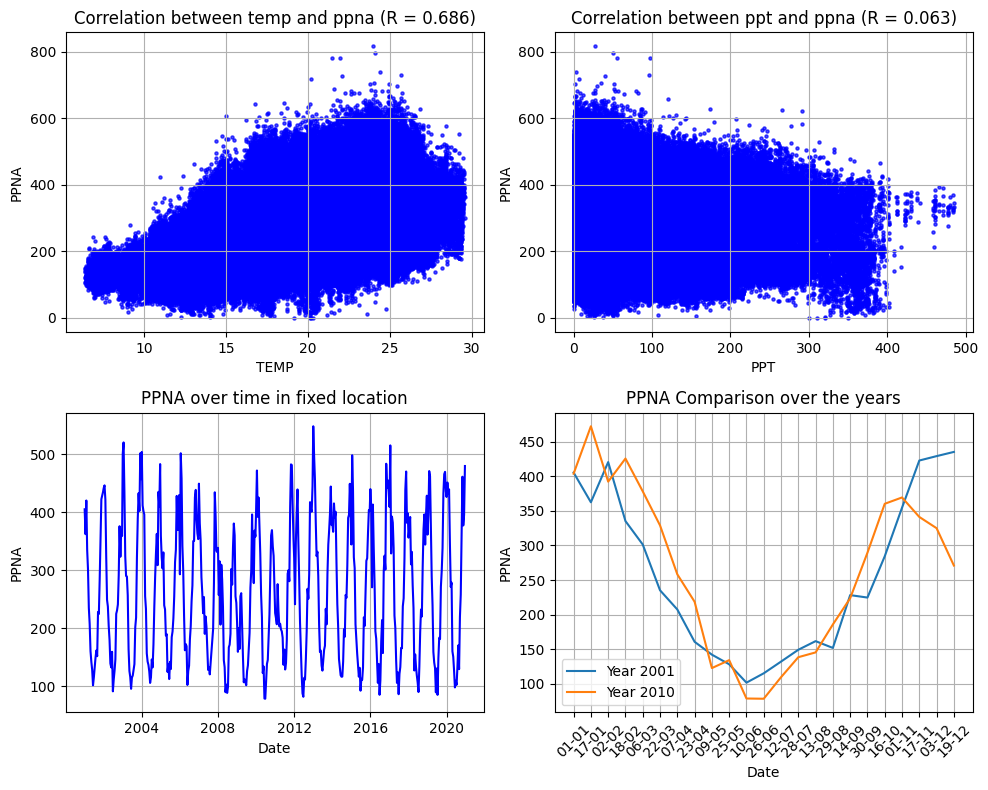

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
pd.options.mode.chained_assignment = None

ppna_df.show_correlation(axes[0,0], 'temp', 'ppna')
ppna_df.show_correlation(axes[0,1], 'ppt', 'ppna')
ppna_df.show_ppna_fixed_position(axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
ppna_df.show_ppna_year_comparision_fixed_position(axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

In [55]:
ppna_df.head()

,id,date,longitude,latitude,ppna,ppt,temp
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910


In [56]:
#ppna_df.show_heat_map()

## Data Managment

In [57]:
"""
Convert from date to timestamp format
""" 
ppna_df.date_to_timestamp()

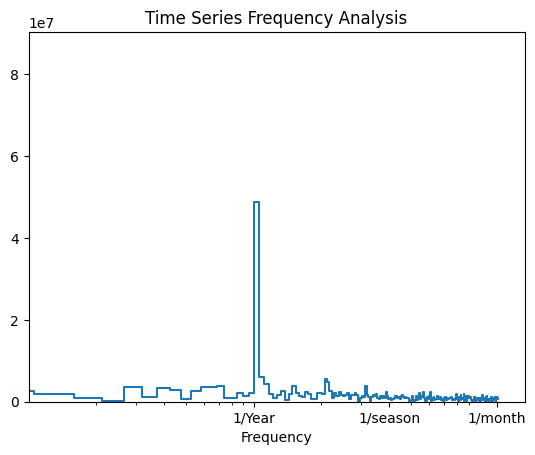

In [58]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

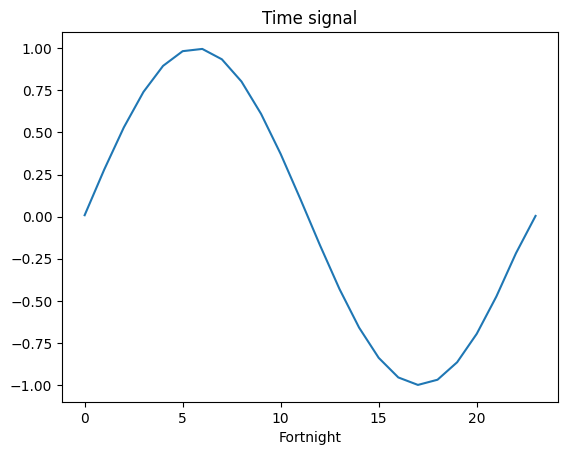

In [59]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')



In [108]:
"""
Divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution. 
As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%,20% and 10%).
The samples are divided secuentially to improve the RNN performance.
"""

train_df = DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

In [109]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_df.normalize_data()
val_df.normalize_data()
test_df.normalize_data()

### Data Window

The models in this proyect will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.


Depending on the task and the type of model, you may want to generate a variety of data windows. Here are a example:
A model making a one-hour prediction into the future, given six hours of history, would need a window like this:

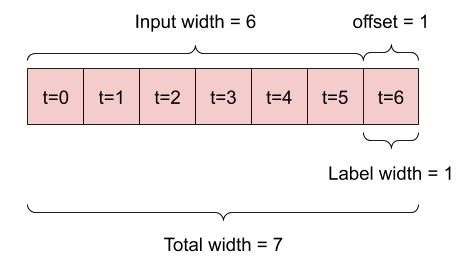

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)


--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

## LSTM

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

### LSTM - One Shot

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

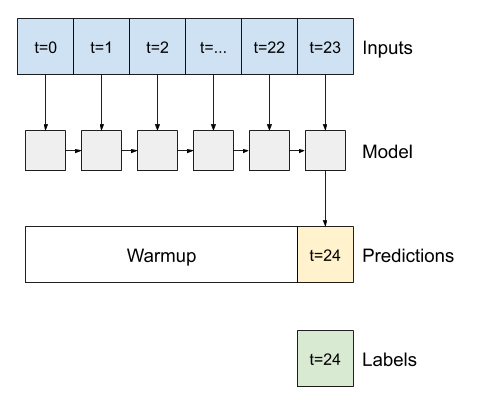

In [136]:
INPUT_STEPS = 24 #1 YEAR
OUTPUT_STEPS = 1 #15 DAYS
NUM_FEATURES = train_df.shape[1]
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUTPUT_STEPS,
                               shift=1, 
                               train_df=test_df,
                               val_df=val_df,
                               test_df=test_df)

In [137]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=5,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [138]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/5
2156/2156 [==============================] - 39s 17ms/step - loss: 191.7795 - mean_absolute_error: 6.7193 - val_loss: 11.6382 - val_mean_absolute_error: 2.0008
Epoch 2/5
2156/2156 [==============================] - 37s 17ms/step - loss: 2.3400 - mean_absolute_error: 1.0136 - val_loss: 0.7643 - val_mean_absolute_error: 0.7274
Epoch 3/5
2156/2156 [==============================] - 40s 18ms/step - loss: 0.7641 - mean_absolute_error: 0.7190 - val_loss: 0.7637 - val_mean_absolute_error: 0.7267
Epoch 4/5
2156/2156 [==============================] - 38s 18ms/step - loss: 0.7640 - mean_absolute_error: 0.7189 - val_loss: 0.7644 - val_mean_absolute_error: 0.7286
Epoch 5/5
2156/2156 [==============================] - 44s 20ms/step - loss: 0.6133 - mean_absolute_error: 0.6301 - val_loss: 0.4972 - val_mean_absolute_error: 0.5594


In [142]:
train_df['ppna']

0         1.296965
1         0.920958
2         1.429294
3         0.682843
4         0.386098
            ...   
689834    1.097307
689835    1.082465
689836    1.450520
689837    2.595092
689838    1.202192
Name: ppna, Length: 448500, dtype: float64

In [139]:
multi_lstm_model.evaluate(multi_window.val)


5390/5390 [==============================] - 22s 4ms/step - loss: 0.4972 - mean_absolute_error: 0.5594


[0.497225284576416, 0.559421956539154]

In [140]:
### Funciones de Ploteo (deberiamos armar una clase y meter todo esto y los de arriba)
# Plotting the training history
def plot_training_history(fig, history, metric):

    validation_metric = f"val_{metric}"

    fig.plot(history.history[metric], label=f"Training {metric}")
    fig.plot(history.history[validation_metric], label=f"Validation {metric}")
    fig.set_xlabel("Epoch")
    fig.set_ylabel(f"{metric}")
    fig.legend()

    merged_mae_lists = history.history[f"{metric}"][0:] + history.history[f"val_{metric}"][0:]
    highest_loss = max(merged_mae_lists)
    lowest_loss = min(merged_mae_lists)
    delta = highest_loss - lowest_loss
    top_of_y_axis = highest_loss + (delta * 0.05)
    bottom_of_y_axis = lowest_loss - (delta * 0.05)

    fig.set_ylim([bottom_of_y_axis, top_of_y_axis])


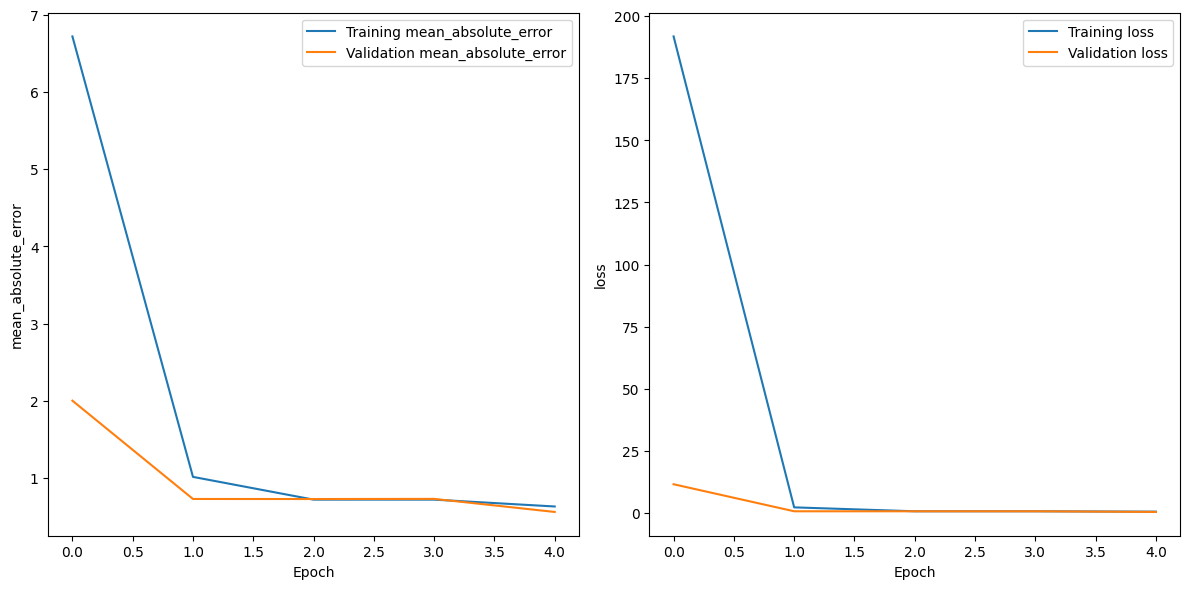

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.options.mode.chained_assignment = None

# plot training history
plot_training_history(axes[0], history, "mean_absolute_error")
plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.tight_layout()
plt.show()